In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal
import matplotlib.pyplot as plt
import numpy as np

from fgan import fgan

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


`Gaussian Example:`

Samples are i.i.d drawn from $(1-\epsilon)\mathcal{N}(0, I_p) + \epsilon N(5, I_p)$ with $\epsilon=0.2$ and $p=100$. We estimate the center parameter $\theta=0$ by f-GAN. In this example, the Generator is setting as, $G_{b}(z)=z + b$ and $z\sim\mathcal{N}(0,I_p)$ that we already know the type of real distribution is Gaussian.

In [3]:
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

import numpy as np
import pandas as pd
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal

from fgan import fgan

# Assume that we are on a CUDA machine, then this should print a CUDA device:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cuda


In [4]:
corps_dict = {
         "Industrial":["LMT", "HON", "UNP", "BA", "MMM", "UPS"],
         "ConsDiscr":["AMZN", "HD", "MCD", "NKE", "SBUX", "LOW"],
         "ConsStaples":["WMT", "PG", "KO", "PEP", "COST", "PM"],
         "Energy":["XOM", "CVX", "COP", "KMI", "PSX", "EOG"],
         "HealthCare":["JNJ", "UNH", "MRK", "PFE", "ABT", "LLY"],
         "Financial":["JPM", "BAC", "WFC", "C", "AXP", "BLK"],
         "InfoTech":["MSFT", "AAPL", "V", "MA", "INTC", "CSCO"],
         "Material":["LIN", "ECL", "APD", "NEM", "SHW", "DD"],
         "Utility":["NEE", "D", "DUK", "SO", "AEP", "SRE"],
         "CommSevs": ["GOOG", "FB", "VZ", "T", "DIS", "NFLX"]
            }

corps = []; sects = [] ## list of corporations and their corresponding sectors
for k, v in corps_dict.items():
    corps += v[:5]
    sects += [k] * 5

tks = yf.Tickers( " ".join(corps) )

START = "2015-01-01"; END = "2020-04-01"
df_price = tks.history(start=START, end=END)["Close"]
df_price = df_price[corps]
df_ret = df_price/df_price.shift(1) # daily return
dropIdx = df_ret["AAPL"].index[ df_ret["AAPL"].apply( np.isnan ) ]
df_ret = df_ret.drop( dropIdx )
logret = np.log( df_ret.to_numpy() ) # daily log-return
logret = logret / logret.std() # re-scale
logret_tensor = torch.from_numpy( logret ).float()

[*********************100%***********************]  50 of 50 completed


In [5]:
logret_tensor.shape

torch.Size([1319, 50])

Initialize Mean Error: 0.3364
Epoch:50, LossD/G:-0.8968/-0.0520, Error(Mean):0.3582
Epoch:100, LossD/G:-0.9486/-0.0312, Error(Mean):0.3650
Epoch:150, LossD/G:-0.9582/-0.0258, Error(Mean):0.3700
Avg error: 0.3688, Last error: 0.3700


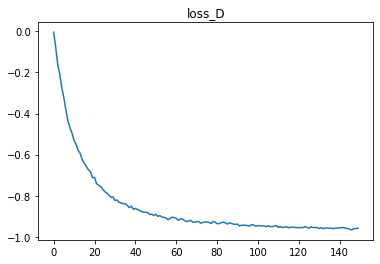

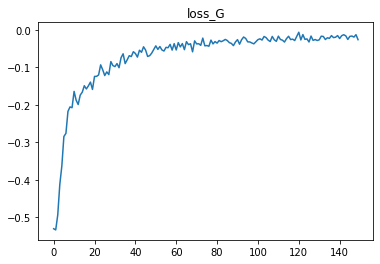

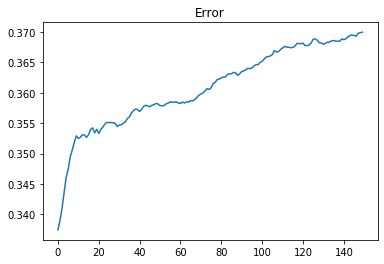

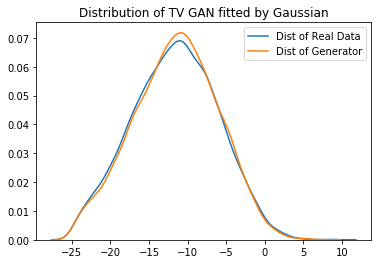

In [6]:
## A more detailed explanation for each argument can be founded in the code.

## Basic settings, dimension p=100, contamination ratio \epsilon=0.2, tol prevents \
## the denomenator being zero.
f = fgan(p=50, eps=0.2, device=device, tol=1e-5)
## Set the type of true distribution and contamination distribution. cont_mean and cont_var 
## give the parameter of contamination. A general contamination covariance matrix can be 
## provided by cont_covmat.
f.dist_init(true_type='Gaussian', cont_type='Gaussian', 
            cont_mean=5.0, cont_var=1.)
## Samples from Huber's contamination model.
f.data_init( data=logret_tensor)
## Settings for Generator and Discriminator. d_hidden_units is a list of hidden units for 
## discriminator, e.g. d_hidden_units=[20] here means the discriminator has structure
## 100(input) - 20(hidden layer) - 1(output). Since (we assume that) we already know the type 
## of distribution is Gaussian, we directly model generator as G(z)=z+b, and elliptical=False.
## activation_D1 is the first activation function after input layer, others are set to be 
## 'LeakyReLU(0.2)' automatically.
f.net_init(d_hidden_units=[20], elliptical=False,g_input_dim=50,activation_D1='LeakyReLU')
## Settings for optimizer. lr_d and lr_g are learning rate for discriminator and generator, 
## respectively. d_steps and g_steps are number of steps per iteration for discriminator and
## generator, respectively.
f.optimizer_init(lr_d=0.2, lr_g=0.02, d_steps=5, g_steps=1)
## floss is the type of f-GAN, and it can be set as 'js'(Jensen-Shannon GAN) and 'tv'(Total
## variation GAN). epochs gives the number of epochs for training. avg_epochs give the number
## of epochs for averaging. verbose and show are printing arguments.
f.fit(floss='tv', epochs=150, avg_epochs=25, verbose=50, show=True)

Initialize Mean Error: 0.3364


/home/wzengad/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/wzengad/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch:50, LossD/G:-0.6438/-0.1988, Error(Mean):0.3405
Epoch:100, LossD/G:-0.7454/-0.1441, Error(Mean):0.3398
Epoch:150, LossD/G:-0.8005/-0.1306, Error(Mean):0.3400
Avg error: 0.3397, Last error: 0.3400


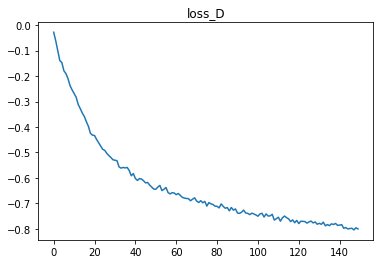

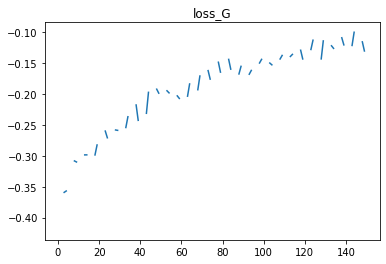

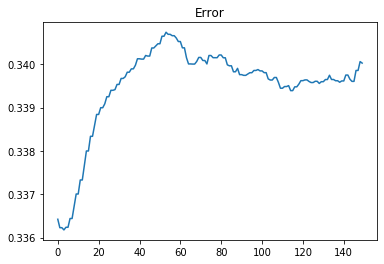

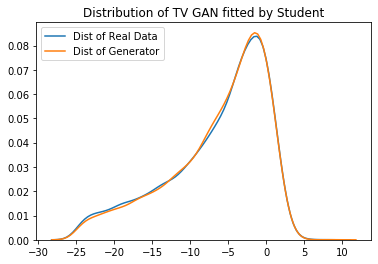

In [7]:
#student t
f = fgan(p=50, eps=0.2, device=device, tol=1e-5)

f.dist_init(true_type='Cauchy', cont_type='Gaussian', 
            cont_mean=5.0, cont_var=1.)

f.data_init(batch_size=500, data=logret_tensor)

f.net_init(d_hidden_units=[20], elliptical=False, activation_D1='LeakyReLU')

f.optimizer_init(lr_d=0.2, lr_g=0.02, d_steps=5, g_steps=1)

f.fit(floss='tv', epochs=150, avg_epochs=25, verbose=50, show=True)

Initialize Mean Error: 0.3364
Epoch:50, LossD/G:-0.5134/-0.3260, Error(Mean):0.3673
Epoch:100, LossD/G:-0.2416/-0.5784, Error(Mean):0.3942
Epoch:150, LossD/G:-0.7622/-0.1400, Error(Mean):0.4621
Avg error: 0.4588, Last error: 0.4621


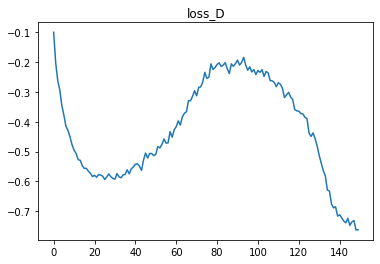

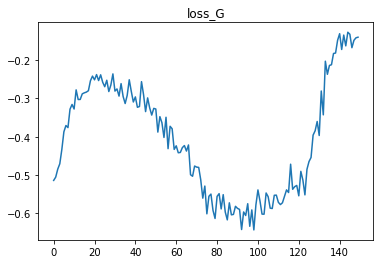

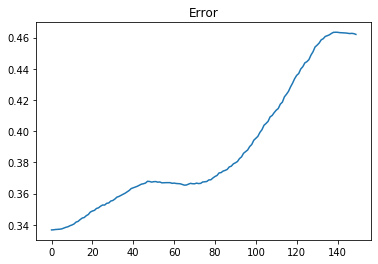

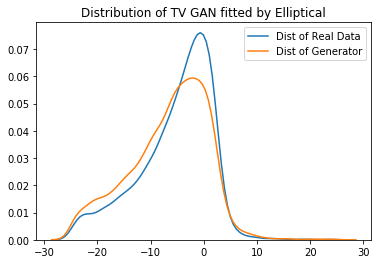

In [8]:
#student t
f = fgan(p=50, eps=0.2, device=device, tol=1e-5)

f.dist_init(true_type='Cauchy', cont_type='Gaussian', 
            cont_mean=5.0, cont_var=1.)

f.data_init(batch_size=200, data=logret_tensor)

f.net_init(d_hidden_units=[20], elliptical=True, activation_D1='LeakyReLU')

f.optimizer_init(lr_d=0.2, lr_g=0.02, d_steps=5, g_steps=1)

f.fit(floss='tv', epochs=150, avg_epochs=25, verbose=50, show=True)